In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from prepare_country_data import transpose_for_country_code, split_and_normalize, cyclical_transformation

/var/folders/bc/ynvgg9rn14v5sl_jcp8x8_s40000gn/T/ipykernel_13022/3592460179.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [12]:
df = pd.read_csv("data/2023/nordic_energy_data.csv")
df_dk1 = transpose_for_country_code(df, "DK_1")
df_dk1 = cyclical_transformation(df_dk1)
df_dk1['Timestamp'] = pd.to_datetime(df_dk1['Timestamp'])
df_feb = df_dk1[df_dk1['Timestamp'].dt.month == 2]
df_feb = df_feb[df_feb['Timestamp'].dt.day <= 14]
X_train, X_test, y_train, y_test, X_train_mean, X_train_std, y_train_mean, y_train_std = split_and_normalize(df_feb)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# make NaN 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

(287, 92) (49, 92) (287,) (49,)


In [13]:
X_train_num = X_train.to_numpy()
X_test_num = X_test.to_numpy()
y_train_num = y_train.to_numpy()
y_test_num = y_test.to_numpy()

In [14]:
def covSE(x1, x2, cov_params=[2.0]):
    return np.exp(-cov_params[0]*np.sum((x1 - x2)**2))

def covPER(x1, x2, cov_params):
    return cov_params[0] * np.exp(-cov_params[1] * np.sum( np.sin(np.pi*(x1-x2)/cov_params[2])**2 ))

def covWN(x1, x2, cov_params):
    if x1.any() == x2.any():
        return cov_params[0]
    else:
        return 0

def cov(x1, x2, cov_fn, cov_params):
    K = np.zeros((len(x1), len(x2)))
    for i in range(len(x1)):
        for j in range(len(x2)):
            K[i,j] = cov_fn(x1[i,:], x2[j,:], cov_params)
    return K

def covSUM_WN_SE(x1, x2, cov_params):
    K = covWN(x1, x2, cov_params[:1]) + covSE(x1, x2, cov_params[1:])
    return K

def covSUM_PER_SE(x1, x2, cov_params):
    return covPER(x1, x2, cov_params[:3]) + covSE(x1, x2, cov_params[3:])

def make_and_plot_cov(X, cov_func, cov_params):

    # construct K
    K = cov(X, X, cov_func, cov_params)
    plt.imshow(K)
    plt.title("Covariance matrix from Gaussian process prior")
    return K

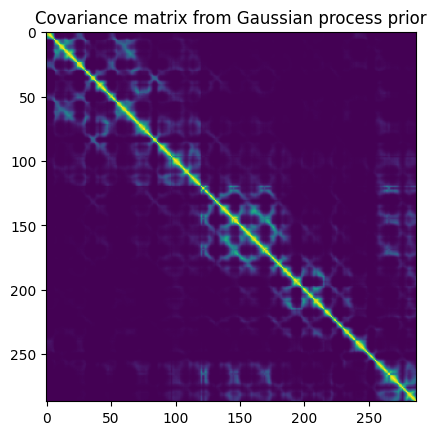

In [15]:
K = make_and_plot_cov(X_train_num, covSE, [0.05])

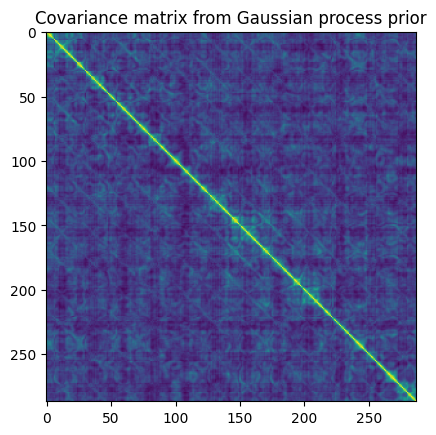

In [16]:
K = make_and_plot_cov(X_train_num, covPER, [0.0001, 0.05, 2])

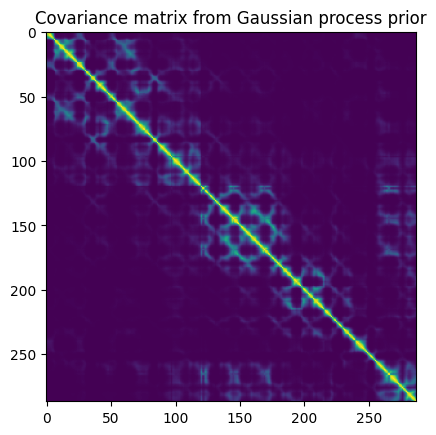

In [17]:
K = make_and_plot_cov(X_train_num, covSUM_PER_SE, [0.01, 0.05, 2, 0.05])

In [18]:
def compute_predictive_posterior(X_test, sigma, cov_params):
    N_test = len(X_test_num)

    predictions = np.zeros(N_test)
    variances = np.zeros(N_test)
    
    # TODO: Compute prediction means and variances for all x_* in the test set.
    # Note that K (and K^{-1}) is the same for all x_*. You don't need to re-compute it every time (slow! O(N^3))

    # K = cov(X_train_num, X_train_num, covSE, cov_params)
    # k_star = cov(X_train_num, X_test_num, covSE, cov_params)
    # k_star_star = cov(X_test_num, X_test_num, covSE, cov_params)

    K = cov(X_train_num, X_train_num, covSUM_PER_SE, [0.01, 0.05, 2, 0.05])
    k_star = cov(X_train_num, X_test_num, covSUM_PER_SE, [0.01, 0.05, 2, 0.05])
    k_star_star = cov(X_test_num, X_test_num, covSUM_PER_SE, [0.01, 0.05, 2, 0.05])
    
    mean = k_star.T @ np.linalg.inv(sigma**2*np.eye(X_train_num.shape[0]) + K) @ y_train_num
    std = k_star_star + sigma**2 - k_star.T @ np.linalg.inv(sigma**2 * np.eye(X_train_num.shape[0]) + K) @ k_star
    
    predictions =  np.random.multivariate_normal(mean.squeeze(), std)

    variances = np.diag(std)
    
    return predictions, variances

cov_params = [0.01, 0.05, 2, 0.05]
sigma = 0.01
predictions, variances = compute_predictive_posterior(X_test, sigma, cov_params)

/var/folders/bc/ynvgg9rn14v5sl_jcp8x8_s40000gn/T/ipykernel_13022/151552366.py:5: RuntimeWarning: invalid value encountered in sin
  return cov_params[0] * np.exp(-cov_params[1] * np.sum( np.sin(np.pi*(x1-x2)/cov_params[2])**2 ))
/var/folders/bc/ynvgg9rn14v5sl_jcp8x8_s40000gn/T/ipykernel_13022/151552366.py:5: RuntimeWarning: invalid value encountered in subtract
  return cov_params[0] * np.exp(-cov_params[1] * np.sum( np.sin(np.pi*(x1-x2)/cov_params[2])**2 ))
/var/folders/bc/ynvgg9rn14v5sl_jcp8x8_s40000gn/T/ipykernel_13022/151552366.py:2: RuntimeWarning: invalid value encountered in subtract
  return np.exp(-cov_params[0]*np.sum((x1 - x2)**2))


LinAlgError: SVD did not converge

In [ ]:
# print error measures
mse = mean_squared_error(y_test_num, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_num, predictions)
print(f"Mean squared error: {mse}")
print(f"Root mean squared error: {rmse}")
print(f"Mean absolute error: {mae}")
plt.figure(figsize=(15, 8))

plt.scatter(y_test[:1000].index, predictions, label="Predicted", color="red")
plt.scatter(y_test[:1000].index, y_test_num, label="Actual", color="blue")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Day Ahead Price DK1", fontsize=14)
plt.title("Simple Linear Regression Model", fontsize=16)
plt.legend()
plt.show()